# Hometask 6

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
DATA_PATH = '/content/'

In [5]:
df = pd.read_csv(DATA_PATH + "train.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Распределение лейблов не сбалансированное. Возможно с этим надо будет что-то сделать.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], 
                                                  df['label'], 
                                                  test_size=0.25, 
                                                  random_state=42, 
                                                  stratify=df['label'])
X_test.head()

15655    @user if only that were true! life is tough so...
21614     @user @user  mate try addressing my argument ...
3197      @user a surprising read to make you    &gt;&g...
12314                       @user @user   father's day â¤
8633     @user    #fathersday gift for proud dads.avail...
Name: tweet, dtype: object

Сделаем лемматизацию

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install spacy
!spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-08 21:32:58.913098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
stop_words = set(get_stop_words("english"))
puncts = set(punctuation)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("dont\s", "dont", txt)
    txt = re.sub("doesnt\s", "doesnt", txt)
    txt = re.sub("didnt\s", "didnt", txt)
    txt = re.sub("havent\s", "havent", txt)
    txt = re.sub("hasnt\s", "hasnt", txt)
    txt = nlp(txt)
    txt = [word.lemma_ for word in txt if word not in stop_words]
    return " ".join(txt)

In [10]:
X_train[1]

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [11]:
X_train = X_train.apply(preprocess_text)
X_train[1]

'user user thank for lyft credit I can not use cause they dontoffer wheelchair van in pdx     disapointe getthanke'

In [12]:
X_test = X_test.apply(preprocess_text)
X_test.head()

15655    user if only that be true life be tough someti...
21614      user user   mate try address my argument rat...
3197       user a surprising read to make you     gtgtg...
12314                          user user    father day â¤
8633     user     fathersday gift for proud dadsavailab...
Name: tweet, dtype: object

Подготовим корпус слов:

In [13]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

Сделаем функцию токенизации:

In [14]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Инициализируем сеть:

In [15]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding1 = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(out_channel, out_channel // 2)
        self.linear4 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding1(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear3(output)
        output = self.relu(output)
        output = self.linear4(output)
        output = F.sigmoid(output)
        return output

Кастомный датасет

In [16]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Лоадеры

In [17]:
def get_loaders(max_len = 20, max_words=2000):
    tokens = word_tokenize(train_corpus)
    tokens_filtered = [word for word in tokens if word.isalnum()]
    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words - 1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
  
    train_dataset = DataWrapper(np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_train]), y_train.values)
    train_loader = DataLoader(train_dataset, batch_size=1024*8, shuffle=True)

    test_dataset = DataWrapper(np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_test]), y_test.values)
    test_loader = DataLoader(test_dataset, batch_size=1024*8, shuffle=True)

    return train_dataset, train_loader, test_dataset, test_loader

In [18]:
train_dataset, train_loader, test_dataset, test_loader = get_loaders()

Смотрим доступные девайсы

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
model = Net()
print(model)

Net(
  (embedding1): Embedding(2000, 128)
  (conv1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=1, bias=True)
)


Функция обучения модели

In [21]:
criterion = nn.BCEWithLogitsLoss()

def learn_net(model, train_loader, test_loader, optimizer, epochs=10, th=0.5):
    model = model.to(device)
    model.train()
    
    train_loss_history = []
    test_loss_history = []


    for epoch in range(epochs):
        model.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # обнуляем градиент
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            # подсчет ошибки на обучении
            running_loss += loss.item()
            running_items += len(labels)
            # подсчет метрики на обучении
            pred_labels = torch.squeeze((outputs > th).int())
            running_right += (labels == pred_labels).sum()
            
        # выводим статистику о процессе обучения
        model.eval()
        
        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                f'Step [{i + 1}/{len(train_loader)}]. ' \
                f'Loss: {running_loss/(i+1):.3f}. ' \
                f'Acc: {running_right / running_items:.3f}', end='. ')
        
        train_loss_history.append(running_loss/(i+1))
        running_loss, running_items, running_right = 0.0, 0.0, 0.0

            # выводим статистику на тестовых данных
        test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
        for j, data in enumerate(test_loader):
            test_labels = data[1].to(device)
            test_outputs = model(data[0].to(device))
            
            # подсчет ошибки на тесте
            test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
            # подсчет метрики на тесте
            test_running_total += len(data[1])
            pred_test_labels = torch.squeeze((test_outputs > th).int())
            test_running_right += (test_labels == pred_test_labels).sum()
        
        test_loss_history.append(test_loss.item()/(j+1))
        print(f'Test loss: {test_loss/(j+1):.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    
    print('Training is finished!')
    return train_loss_history, test_loss_history

Посмотрим, как количество слов влияет на результаты

In [30]:
losses_train = []
losses_test = []
for it in [1000, 2000, 3000]:
    train_dataset, train_loader, test_dataset, test_loader = get_loaders(max_words=20)
    model = Net(vocab_size=it)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_history, test_loss_history = learn_net(model, train_loader, test_loader, optimizer)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)

Epoch [1/10]. Step [3/3]. Loss: 0.893. Acc: 0.929. Test loss: 0.812. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.770. Acc: 0.930. Test loss: 0.708. Test acc: 0.930
Epoch [3/10]. Step [3/3]. Loss: 0.700. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [4/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [5/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [6/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [7/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [8/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [9/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [10/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Training is finished!
Epoch [1/10]. Step [3/3]. Loss: 0.914. Acc: 0.636. Test loss: 0.844. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.803. Acc

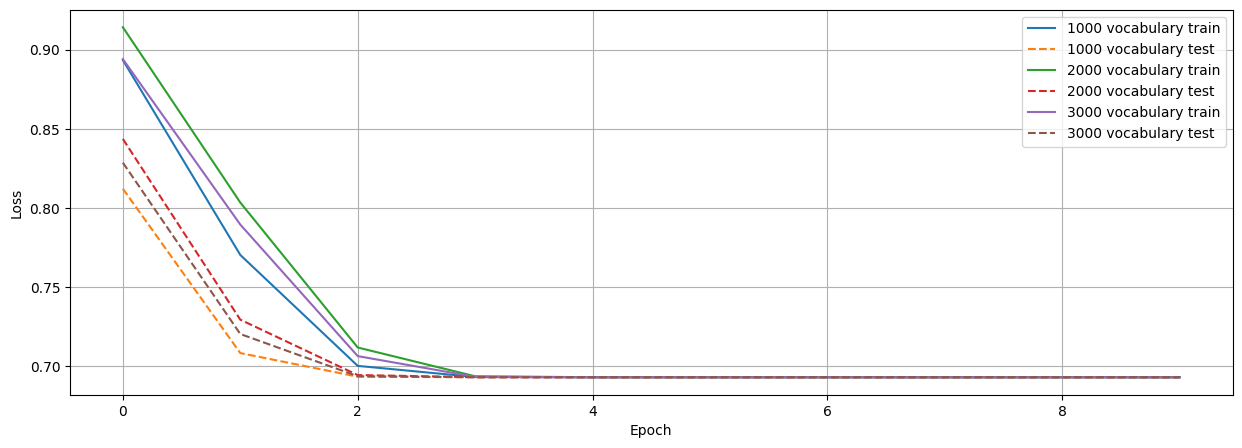

In [31]:
plt.figure(figsize = (15,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{(i+1)*1000} vocabulary train')
    plt.plot(losses_test[i],'--',label = f'{(i+1)*1000} vocabulary test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

Сеть достигает возможного максимума обучения за 3-4 эпохи.

Попробуем увеличить количество скрытых слоев.

In [32]:
losses_train = []
losses_test = []
for it in [1000, 2000, 3000]:
    train_dataset, train_loader, test_dataset, test_loader = get_loaders(max_words=20)
    model = Net(vocab_size=it, embedding_dim=256, out_channel=256)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_history, test_loss_history = learn_net(model, train_loader, test_loader, optimizer)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)

Epoch [1/10]. Step [3/3]. Loss: 0.874. Acc: 0.636. Test loss: 0.729. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.707. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [3/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [4/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [5/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [6/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [7/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [8/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [9/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [10/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Training is finished!
Epoch [1/10]. Step [3/3]. Loss: 0.849. Acc: 0.922. Test loss: 0.706. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.698. Acc

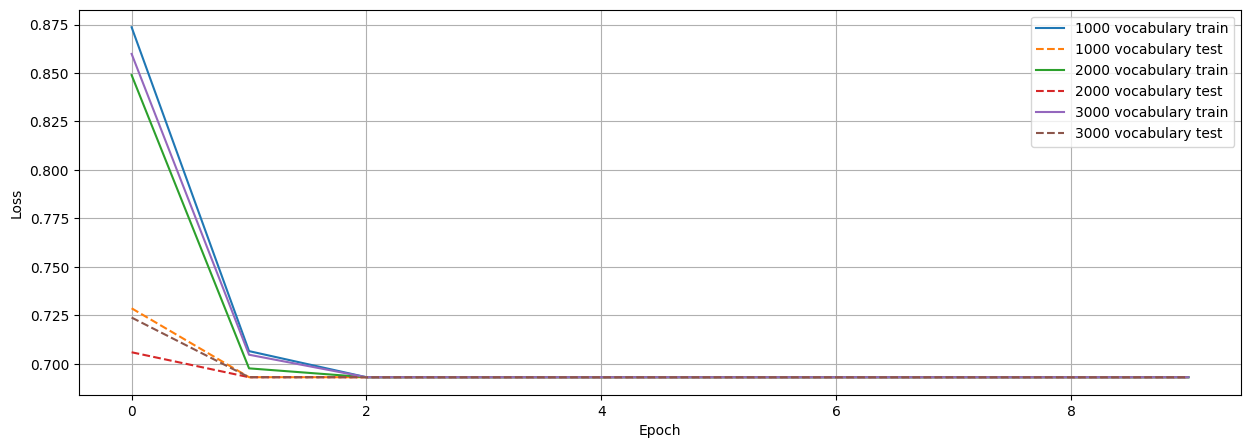

In [33]:
plt.figure(figsize = (15,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{(i+1)*1000} vocabulary train')
    plt.plot(losses_test[i],'--',label = f'{(i+1)*1000} vocabulary test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

За две эпохи максимум.

In [34]:
losses_train = []
losses_test = []
for it in [1000, 2000, 3000]:
    train_dataset, train_loader, test_dataset, test_loader = get_loaders(max_words=20)
    model = Net(vocab_size=it, embedding_dim=64, out_channel=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_history, test_loss_history = learn_net(model, train_loader, test_loader, optimizer)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)

Epoch [1/10]. Step [3/3]. Loss: 0.921. Acc: 0.919. Test loss: 0.903. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.894. Acc: 0.930. Test loss: 0.876. Test acc: 0.930
Epoch [3/10]. Step [3/3]. Loss: 0.864. Acc: 0.930. Test loss: 0.836. Test acc: 0.930
Epoch [4/10]. Step [3/3]. Loss: 0.818. Acc: 0.930. Test loss: 0.779. Test acc: 0.930
Epoch [5/10]. Step [3/3]. Loss: 0.760. Acc: 0.930. Test loss: 0.727. Test acc: 0.930
Epoch [6/10]. Step [3/3]. Loss: 0.716. Acc: 0.930. Test loss: 0.701. Test acc: 0.930
Epoch [7/10]. Step [3/3]. Loss: 0.698. Acc: 0.930. Test loss: 0.694. Test acc: 0.930
Epoch [8/10]. Step [3/3]. Loss: 0.694. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [9/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [10/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Training is finished!
Epoch [1/10]. Step [3/3]. Loss: 0.938. Acc: 0.542. Test loss: 0.919. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.909. Acc

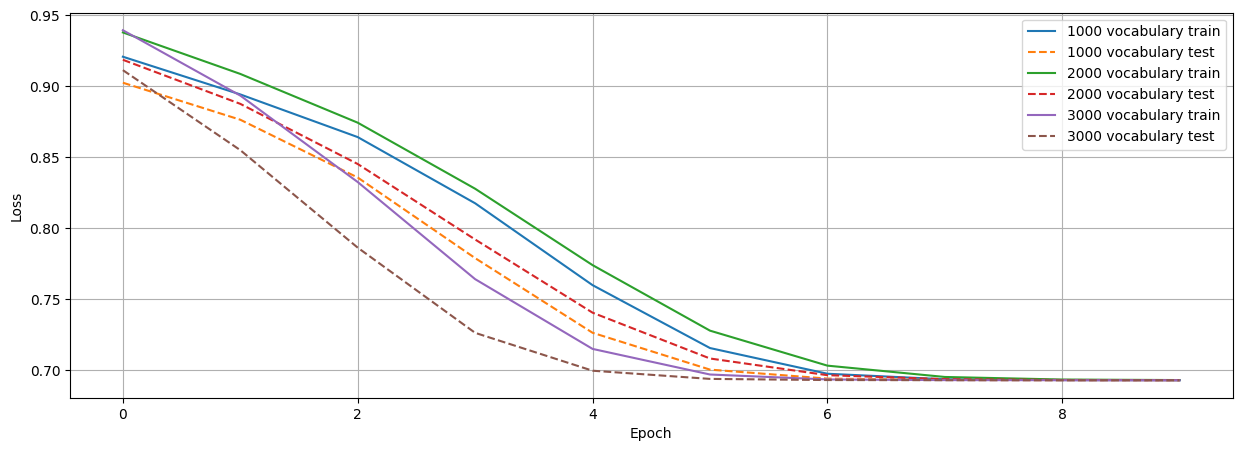

In [35]:
plt.figure(figsize = (15,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{(i+1)*1000} vocabulary train')
    plt.plot(losses_test[i],'--',label = f'{(i+1)*1000} vocabulary test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

Стала видна зависимость метрик от количества скрытых слоев.

Поэкспериментируем с количеством слов в предложении.

In [36]:
losses_train = []
losses_test = []
for it in [5, 10, 20, 30]:
    train_dataset, train_loader, test_dataset, test_loader = get_loaders(max_words=it)
    model = Net(vocab_size=2000, embedding_dim=64, out_channel=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_history, test_loss_history = learn_net(model, train_loader, test_loader, optimizer)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)

Epoch [1/10]. Step [3/3]. Loss: 0.944. Acc: 0.346. Test loss: 0.928. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.921. Acc: 0.930. Test loss: 0.906. Test acc: 0.930
Epoch [3/10]. Step [3/3]. Loss: 0.896. Acc: 0.930. Test loss: 0.870. Test acc: 0.930
Epoch [4/10]. Step [3/3]. Loss: 0.853. Acc: 0.930. Test loss: 0.815. Test acc: 0.930
Epoch [5/10]. Step [3/3]. Loss: 0.794. Acc: 0.930. Test loss: 0.753. Test acc: 0.930
Epoch [6/10]. Step [3/3]. Loss: 0.737. Acc: 0.930. Test loss: 0.712. Test acc: 0.930
Epoch [7/10]. Step [3/3]. Loss: 0.705. Acc: 0.930. Test loss: 0.697. Test acc: 0.930
Epoch [8/10]. Step [3/3]. Loss: 0.695. Acc: 0.930. Test loss: 0.694. Test acc: 0.930
Epoch [9/10]. Step [3/3]. Loss: 0.694. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Epoch [10/10]. Step [3/3]. Loss: 0.693. Acc: 0.930. Test loss: 0.693. Test acc: 0.930
Training is finished!
Epoch [1/10]. Step [3/3]. Loss: 0.913. Acc: 0.930. Test loss: 0.891. Test acc: 0.930
Epoch [2/10]. Step [3/3]. Loss: 0.878. Acc

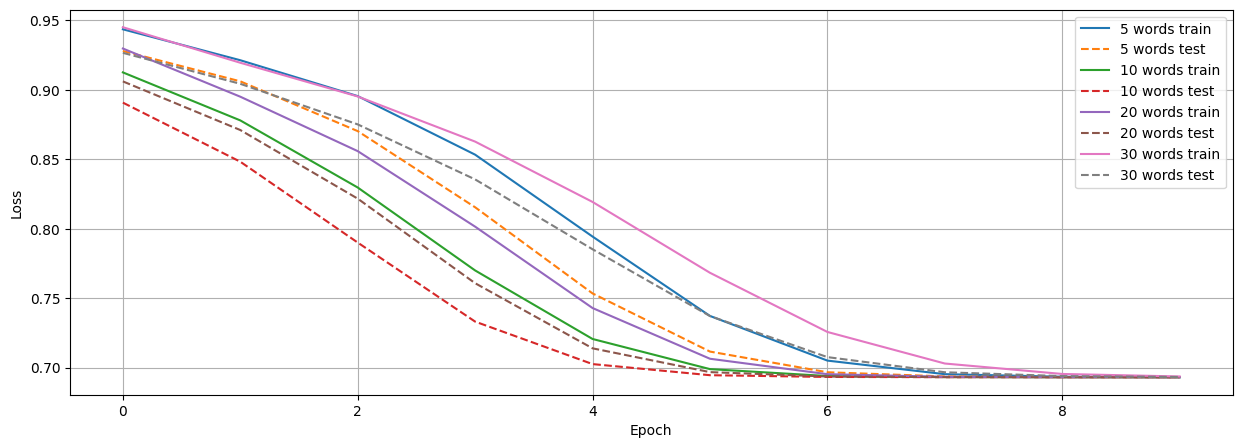

In [38]:
plt.figure(figsize = (15,5))
for i, it in enumerate((5, 10, 20, 30)):
    plt.plot(losses_train[i],'-',label = f'{it} words train')
    plt.plot(losses_test[i],'--',label = f'{it} words test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

Подозреваю, что для данных текстов надо делать большую предварительную обработку. Анализировать текст не только автоматическими средствами, но и вручную.

Наиболее быстрого обучения можно добиться, если в сети будет множество скрытых слоев. И на удивление, но за 5 слов (вместо 30) можно быстрее обучить сеть, чтобы определить сентимент сообщения.